In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd
import rdata
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import time
import matplotlib
import matplotlib.pyplot as plt
import math

D:\Programme\Miniconda\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
def plot_images(images_list, labels):
    n = round(math.sqrt(len(images_list)))
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(create_maldi_image(images_list[i*n+j]), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(labels[i*n+j])
    plt.savefig('plot.png')
    plt.show()
    
def create_maldi_image(spectra_list):
    # Get the dimensions of the image
    n = int(math.sqrt(len(spectra_list)))
    # Create an empty numpy array to store the maldi image
    maldi_image = np.zeros((n, n))
    
    # Loop over each pixel in the image and assign the corresponding spectra
    for row in range(n):
        for col in range(n):
            avg_value = np.sum(spectra_list[row * n + col]) / len(spectra_list[row * n + col])
            #maldi_image[row, col] = int(avg_value * 255)
            maldi_image[row, col] = np.round(avg_value * 255).astype(np.uint8)
            
    return maldi_image

In [3]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    if len(maxima) == 0:
        return -1
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)
    
def getPersistenceTransformation_old(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

def getPersistenceTransformationFixxed(data_X, number_of_peaks):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        

    transformationForSpectra = []
    for i in range(0, len(spectras)):
        transformation = [0] * len(data_X.iloc[i])
        if len(spectras[i]) == 1:
            k = 0
        else:
            k = number_of_peaks
        featurePairs = spectras[i][0:k]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    return transformationForSpectra

def getPersistenceTransformation(data_X):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
    return spectras
                
       
def getPercantageForSpectra(spectras, length, k):
    transformationForSpectra = []
    for i in range(0, len(spectras)):
        if len(spectras[i]) == 1:
            var_k = 0
        else:
            var_k = k
        transformation = [0] * length
        featurePairs = spectras[i][0:round(var_k*len(spectras[i]))]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    
    return transformationForSpectra

In [4]:
def read_data(path):
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    data = np.array(list(converted.values()))[0]
    return data

def read_csv_data(path):
    # Read the CSV file
    #with open(path, "r") as csv_file:
    #    reader = csv.reader(csv_file)
    #    data = list(reader)

    # Convert the data to a NumPy array
    #np_data = np.array(data, dtype=float)

    # Print the NumPy array
    #return np_data
    
    # Load CSV file into NumPy array
    data = np.genfromtxt(path, delimiter=',', skip_header=1)
    return np.transpose(data[:, 1:])

In [5]:
def add_gaussian_noise(image, mean=0, std=1, seed=None):
    """Add Gaussian noise to a 2D numpy array."""
    if seed is not None:
        np.random.seed(seed)
    #noise = np.random.normal(mean, std, size=image.shape)
    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    return image + noise

def add_poisson_noise(matrix, lam=1, seed=None):
    """Add Poisson noise to a matrix.

    Args:
        matrix (numpy.ndarray): The matrix to add noise to.
        lam (float): The intensity parameter of the Poisson distribution.
        seed (int): The seed value for the random number generator.

    Returns:
        numpy.ndarray: The noisy matrix.

    """
    if seed is not None:
        np.random.seed(seed)

    noisy_matrix = np.random.poisson(lam=lam, size=matrix.shape)
    noisy_matrix = matrix + noisy_matrix.astype(np.float32)

    return noisy_matrix

    return noisy_img

def add_salt_noise(matrix, percentage):
   
    # Create a copy of the matrix to modify
    noisy_matrix = np.copy(matrix)

    # Determine the number of pixels to salt
    num_pixels = int(percentage * len(matrix))

    # Generate a random set of indices for the pixels to salt
    indices = np.random.choice(len(matrix), size=num_pixels, replace=False)

    # Replace the pixels at the chosen indices with a high value (255)
    for ind in indices:
        for value in matrix[ind]:
            noisy_matrix[ind][int(value)] = 50.
    
    return noisy_matrix

def add_speckle_noise(image, std = 0.1):
    
    np.random.seed(123)
    s =  image.shape
    gauss = np.random.randn(s[0], s[1])
    #gauss = gauss.reshape(s[0], s[1])     
        
    noisy_matrix = image + image * gauss
    
    return noisy_matrix

In [6]:
def calculate_snr(image, noisy_image):
    # Calculate the mean of the signal
    signal_mean = np.mean(image)

    # Calculate the mean of the noise
    noise_mean = np.mean(noisy_image - image)

    # Calculate the standard deviation of the noise
    noise_std = np.std(noisy_image - image)

    # Calculate the signal-to-noise ratio (SNR), 
    
    snr = 10 * np.log10((signal_mean - noise_mean) / noise_std)

    return snr

In [7]:
def apply_pt(data, noise_type, k0, k1, lam, mean = 0, std = 0.3, seed = 123, percentage = .01, baseline = 0):
    
    if noise_type == 'gaussian':
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        #caption = 'Gaussian Noise,\nmean = {}, std = {}'.format(mean, std)
        #save = 'gaussian_k_{}_mean_{}_std_{}_baseline_{}_size_{:.0f}x{:.0f}'.format(k, mean, std, baseline, math.sqrt(len(data)) ,math.sqrt(len(data)))
    elif noise_type == 'poisson':
        noisy_data = add_poisson_noise(data, lam = lam, seed=seed)
        #caption = 'Poisson Noise,\nlam = {}'.format(lam)
        #save = 'poisson_k_{}_lam_{}_baseline_{}_size_{:.0f}x{:.0f}'.format(k, lam, baseline, math.sqrt(len(data)) ,math.sqrt(len(data)))
    elif noise_type == 'salt':
        noisy_data = add_salt_noise(data, percentage)
        #caption = 'Salt Noise,\npercantage = {}'.format(percentage)
        #save='Unnamed'
    elif noise_type == 'speckle':
        noisy_data = add_speckle_noise(data)
        #caption = 'Pepper Noise,\npercantage = {}'.format(percentage)
        #save='Unnamed'
    else:
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        #caption = 'Noise'
        #save='Unnamed'
    
    st = time.time()
    pt_data = getPersistenceTransformation(data_X = noisy_data)
    et = time.time()   
    analyse_time = et - st
    
    pt_k0 = getPercantageForSpectra(pt_data, len(noisy_data[0]), k0)
    
    pt_k1 = getPercantageForSpectra(pt_data, len(noisy_data[0]), k1)
    
    img = create_maldi_image(data)
    
    img_noise = create_maldi_image(noisy_data)
    
    img_k0 = create_maldi_image(pt_k0)
    
    img_k1 = create_maldi_image(pt_k1)
    
    images = [img, img_noise, img_k0, img_k1]
    
    snr = calculate_snr(img, img_noise)
    
    return img, img_noise, img_k0, img_k1, snr
    

In [8]:
def mse_pic(y_actual, y_predicted):
    
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    
    RMSE = math.sqrt(MSE)
    
    return RMSE

In [9]:
def plotting_function(ground_truth, noise, denoising_low_per, denoising_high_per, snr):
    
    matplotlib.style.use('ggplot')

    fig = plt.figure(figsize=(10, 10), dpi=100)

    fig, axs = plt.subplots(3, 4)

    axs[0, 0].imshow(ground_truth[0], cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Ground truth,\n Baseline = 0")
    axs[0, 1].imshow(noise[0], cmap='gray')
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(snr[0])))
    axs[0, 2].imshow(denoising_low_per[0], cmap='gray')
    axs[0, 2].axis('off')
    axs[0, 2].set_title('Persistance k = 5%\n RMSE:{} '.format(round(mse_pic(ground_truth[0], denoising_low_per[0]))))
    axs[0, 3].imshow(denoising_high_per[0], cmap='gray')
    axs[0, 3].axis('off')
    axs[0, 3].set_title('Persistance k = 10%\n RMSE: {}'. format(round(mse_pic(ground_truth[0], denoising_high_per[0]))))

    axs[1, 0].imshow(ground_truth[1], cmap='gray')
    axs[1, 0].axis('off')
    axs[1, 0].set_title("Ground truth,\n Baseline = 0")
    axs[1, 1].imshow(noise[1], cmap='gray')
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(snr[1])))
    axs[1, 2].imshow(denoising_low_per[1], cmap='gray')
    axs[1, 2].axis('off')
    axs[1, 2].set_title('Persistance k = 5%\n RMSE:{}'.format(round(mse_pic(ground_truth[1], denoising_low_per[1]))))
    axs[1, 3].imshow(denoising_high_per[1], cmap='gray')
    axs[1, 3].axis('off')
    axs[1, 3].set_title('Persistance k = 10%\n RMSE:{}'.format(round(mse_pic(ground_truth[1], denoising_high_per[1]))))

    axs[2, 0].imshow(ground_truth[2], cmap='gray')
    axs[2, 0].axis('off')
    axs[2, 0].set_title("Ground truth,\n Baseline = 0")
    axs[2, 1].imshow(noise[2], cmap='gray')
    axs[2, 1].axis('off')
    axs[2, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(snr[2])))
    axs[2, 2].imshow(denoising_low_per[2], cmap='gray')
    axs[2, 2].axis('off')
    axs[2, 2].set_title('Persistance k = 5%\n  RMSE:{}'.format(round(mse_pic(ground_truth[2], denoising_low_per[2]))))
    axs[2, 3].imshow(denoising_high_per[2], cmap='gray')
    axs[2, 3].axis('off')
    axs[2, 3].set_title('Persistance k = 10%\n  RMSE:{}'.format(round(mse_pic(ground_truth[2], denoising_high_per[2]))))

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.5,
                        top=2,
                        wspace=0.2,
                        hspace=0.2)

In [323]:
#### Generating figure for the Gaussian noise

gaus_sd_0_1 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', mean = 0.1, std = 0.1,
            k0 = 0.05, k1 = 0.1)

gaus_sd_0_3 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', mean = 0.1, std = 0.3,
            k0 = 0.05, k1 = 0.1)

gaus_sd_0_5 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', mean = 0.1, std = 0.5,
            k0 = 0.05, k1 = 0.1)

In [339]:
ground_truth_gaus_30_30 = [gaus_sd_0_1[0], gaus_sd_0_3[0], gaus_sd_0_5[0]]
noise_images_gaus_30_30 = [gaus_sd_0_1[1], gaus_sd_0_3[1], gaus_sd_0_5[1]]
pers_low_30_30  = [gaus_sd_0_1[2], gaus_sd_0_3[2], gaus_sd_0_5[2]]
pers_high_30_30 = [gaus_sd_0_1[3], gaus_sd_0_3[3], gaus_sd_0_5[3]]
snr_30_30       = [gaus_sd_0_1[4], gaus_sd_0_3[4], gaus_sd_0_5[4]]

<Figure size 1000x1000 with 0 Axes>

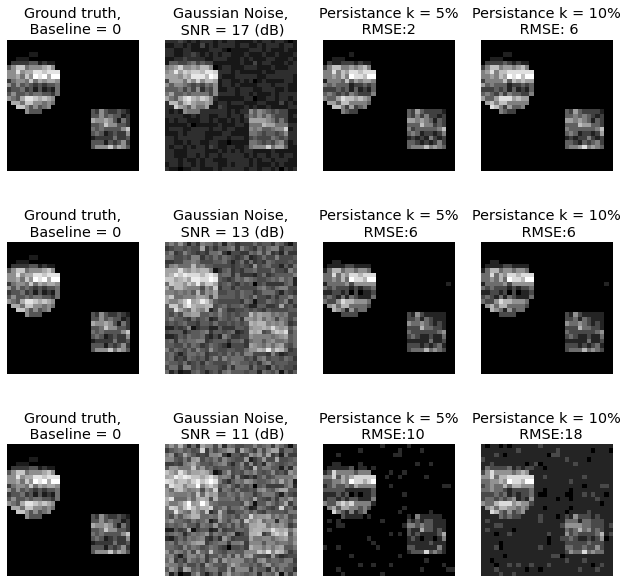

In [341]:
plotting_function(ground_truth_gaus_30_30, noise_images_gaus_30_30, pers_low_30_30, pers_hig_30_30, snr_30_30)

In [362]:
#### Generating figure for the Poisson noise

speckle_1 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'speckle', 
            k0 = 0.01, k1 = 0.5)

speckle_2 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'speckle',
            k0 = 0.01, k1 = 0.05)

speckle_3 = apply_pt(data = read_data("data/image_data.RData"), noise_type = 'speckle',
            k0 = 0.01, k1 = 0.05)

TypeError: apply_pt() missing 1 required positional argument: 'lam'

In [333]:
ground_truth_speckle_30_30 = [pois_1[0], pois_2[0], pois_3[0]]
noise_images_speckle_30_30 = [pois_1[1], pois_2[1], pois_3[1]]
pers_low_speckle_30_30  = [pois_1[2], pois_2[2], pois_3[2]]
pers_high_speckle_30_30 = [pois_1[3], pois_2[3], pois_3[3]]
snr_speckle_30_30       = [pois_1[4], pois_2[4], pois_3[4]]

<Figure size 1000x1000 with 0 Axes>

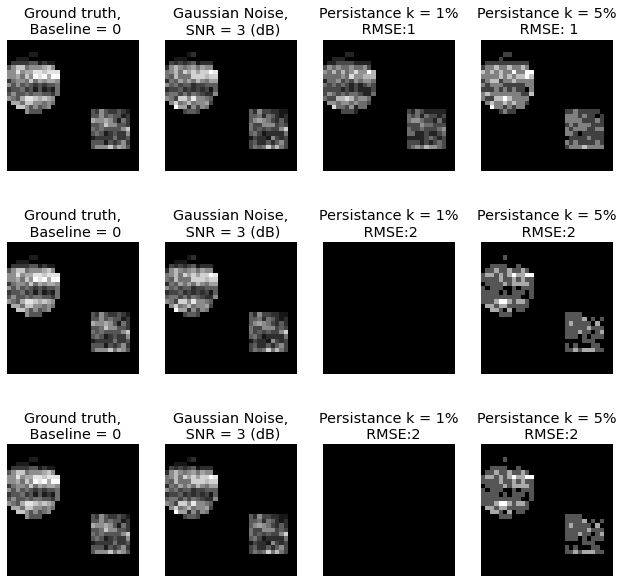

In [334]:
plotting_function(ground_truth_speckle_30_30,
                  noise_images_speckle_30_30, pers_low_speckle_30_30, pers_high_speckle_30_30, snr_speckle_30_30)

In [159]:
b = read_data("data/image_data.RData")

In [104]:
#### Generating figure for the Gaussian noise

gaus_sd_0_1_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'gaussian',
                    mean = 0.1, std = 0.1, k0 = 0.01, k1 = 0.05)

gaus_sd_0_3_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'gaussian', 
                       mean = 0.1, std = 0.3, k0 = 0.01, k1 = 0.05)

gaus_sd_0_5_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'gaussian',
                       mean = 0.1, std = 0.5, k0 = 0.01, k1 = 0.05)

<Figure size 1000x1000 with 0 Axes>

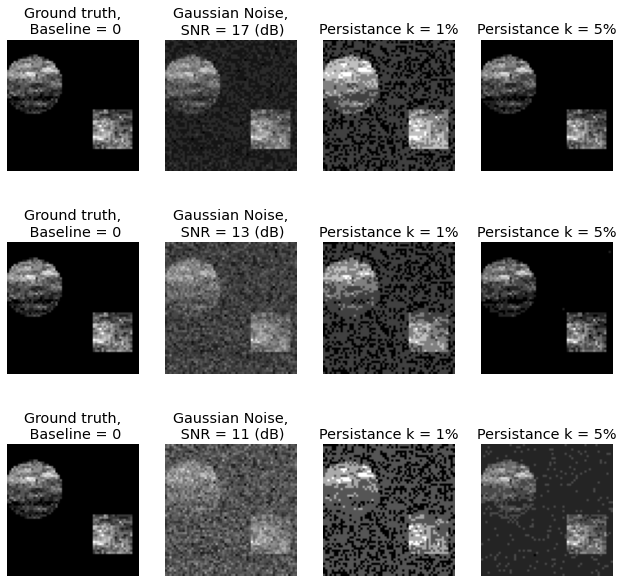

In [110]:
matplotlib.style.use('ggplot')

fig = plt.figure(figsize=(10, 10), dpi=100)

fig, axs = plt.subplots(3, 4)

axs[0, 0].imshow(gaus_sd_0_1_large [0], cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title("Ground truth,\n Baseline = 0")
axs[0, 1].imshow(gaus_sd_0_1_large [1], cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(gaus_sd_0_1_large[4])))
axs[0, 2].imshow(gaus_sd_0_1_large[2], cmap='gray')
axs[0, 2].axis('off')
axs[0, 2].set_title('Persistance k = 1%')
axs[0, 3].imshow(gaus_sd_0_1_large[3], cmap='gray')
axs[0, 3].axis('off')
axs[0, 3].set_title('Persistance k = 5%')

axs[1, 0].imshow(gaus_sd_0_3_large[0], cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title("Ground truth,\n Baseline = 0")
axs[1, 1].imshow(gaus_sd_0_3_large[1], cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(gaus_sd_0_3_large[4])))
axs[1, 2].imshow(gaus_sd_0_3_large[2], cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].set_title('Persistance k = 1%')
axs[1, 3].imshow(gaus_sd_0_3_large[3], cmap='gray')
axs[1, 3].axis('off')
axs[1, 3].set_title('Persistance k = 5%')

axs[2, 0].imshow(gaus_sd_0_5_large[0], cmap='gray')
axs[2, 0].axis('off')
axs[2, 0].set_title("Ground truth,\n Baseline = 0")
axs[2, 1].imshow(gaus_sd_0_5_large[1], cmap='gray')
axs[2, 1].axis('off')
axs[2, 1].set_title('Gaussian Noise,\n SNR = {} (dB)'.format(round(gaus_sd_0_5_large[4])))
axs[2, 2].imshow(gaus_sd_0_5_large[2], cmap='gray')
axs[2, 2].axis('off')
axs[2, 2].set_title('Persistance k = 1%')
axs[2, 3].imshow(gaus_sd_0_5_large[3], cmap='gray')
axs[2, 3].axis('off')
axs[2, 3].set_title('Persistance k = 5%')

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=2,
                    wspace=0.2,
                    hspace=0.2)

In [361]:
#### Generating figure for the Gaussian noise

pois_1_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'poisson', 
                      lam = 0.1, k0 = 0.2, k1 = 0.35)

pois_2_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'poisson', 
                       lam = 0.2,  k0 = 0.2, k1 = 0.35)

pois_3_large = apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_0.RData"), noise_type = 'poisson',
                       lam = 0.3,  k0 = 0.2, k1 = 0.35)

In [359]:
ground_truth_pois_60_60 = [pois_1_large[0], pois_2_large[0], pois_3_large[0]]
noise_images_pois_60_60 = [pois_1_large[1], pois_2_large[1], pois_3_large[1]]
pers_low_pois_60_60  = [pois_1_large[2], pois_2_large[2], pois_3_large[2]]
pers_high_pois_60_60 = [pois_1_large[3], pois_2_large[3], pois_3_large[3]]
snr_pois_60_60       = [pois_1_large[4], pois_2_large[4], pois_3_large[4]]

<Figure size 1000x1000 with 0 Axes>

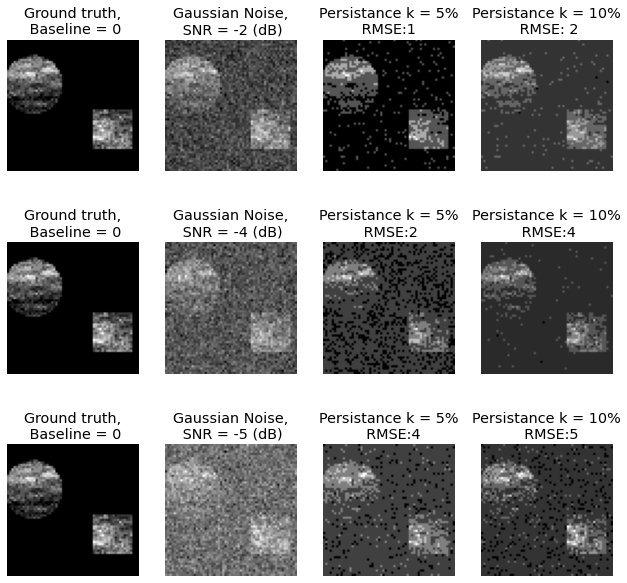

In [360]:
plotting_function(ground_truth_pois_60_60,
                  noise_images_pois_60_60, pers_low_pois_60_60, pers_high_pois_60_60, snr_pois_60_60)